In [1]:
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
from PIL import Image

/home/public/.miniconda3/envs/omni/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
/home/public/.miniconda3/envs/omni/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda'
som_model_path='weights/icon_detect/model.pt'

som_model = get_yolo_model(som_model_path)
som_model = som_model.to(device)

In [3]:
caption_model_processor = get_caption_model_processor(model_name="florence2",
                                                      model_name_or_path="weights/icon_caption_florence",
                                                      device=device)

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
image_path = 'imgs/word.png'
image = Image.open(image_path).convert('RGB')

In [5]:
box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

(ocr_text, ocr_bbox), _ = check_ocr_box(image_path,
                                 display_img = False,
                                 output_bb_format='xyxy',
                                 goal_filtering=None,
                                 easyocr_args={'paragraph': False, 'text_threshold':0.9},
                                 use_paddleocr=True)

dino_labeled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path,
                                                                              som_model,
                                                                              BOX_TRESHOLD = BOX_TRESHOLD,
                                                                              output_coord_in_ratio=True,
                                                                              ocr_bbox=ocr_bbox,
                                                                              draw_bbox_config=draw_bbox_config,
                                                                              caption_model_processor=caption_model_processor,
                                                                              ocr_text=ocr_text,
                                                                              use_local_semantics=True,
                                                                              iou_threshold=0.7,
                                                                              scale_img=False,
                                                                              batch_size=128)


0: 736x1280 115 icons, 21.5ms
Speed: 5.9ms preprocess, 21.5ms inference, 57.2ms postprocess per image at shape (1, 3, 736, 1280)
len(filtered_boxes): 128 41
time to get parsed content: 0.21928048133850098


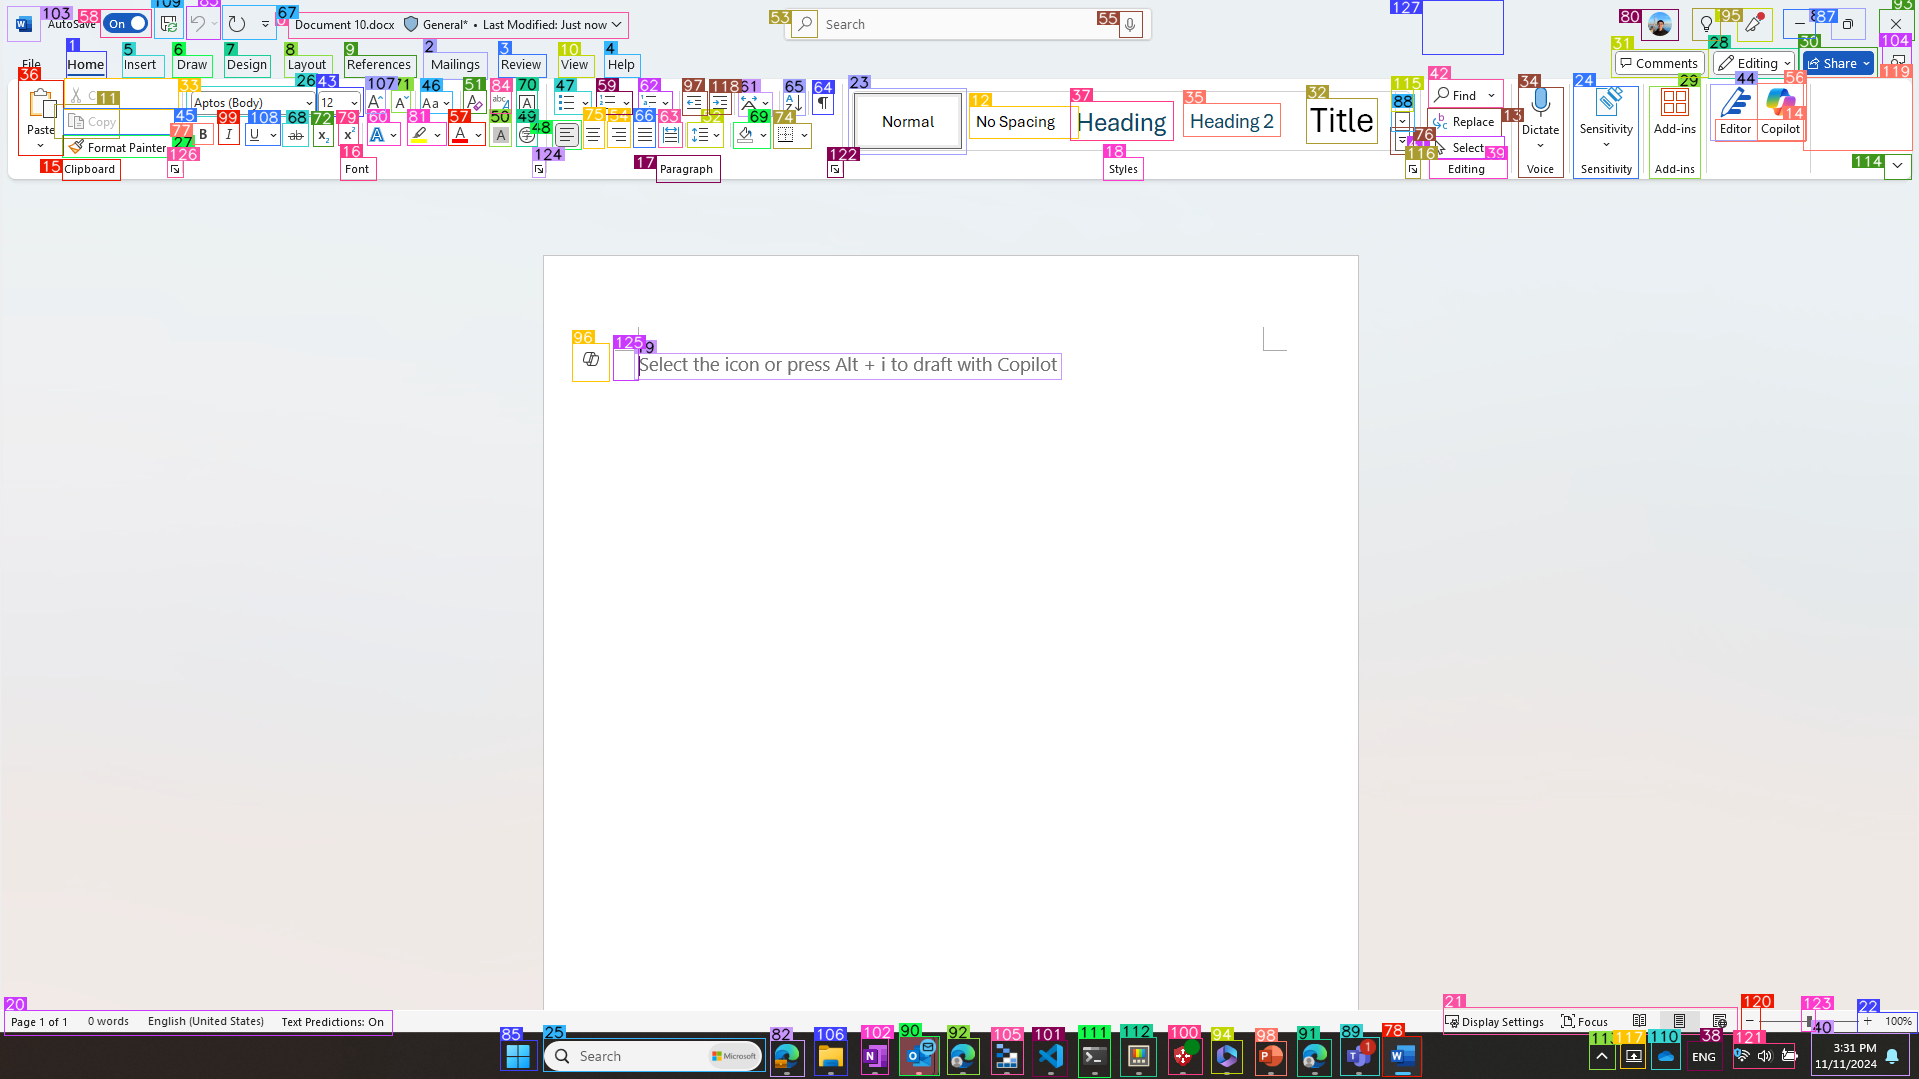

In [6]:
display(dino_labeled_img)

In [8]:
import pandas as pd

df = pd.DataFrame(parsed_content_list)
df.head()

,type,bbox,interactivity,content,source
0,text,"[0.1500781625509262, 0.011121409013867378, 0.3...",False,Document 10.docx General* Last Modified: Jus...,box_ocr_content_ocr
1,text,"[0.034392911940813065, 0.04726598784327507, 0....",False,Home,box_ocr_content_ocr
2,text,"[0.22094841301441193, 0.048192769289016724, 0....",False,Mailings,box_ocr_content_ocr
3,text,"[0.2595101594924927, 0.05004633963108063, 0.28...",False,Review,box_ocr_content_ocr
4,text,"[0.31474727392196655, 0.05004633963108063, 0.3...",False,Help,box_ocr_content_ocr
